In [85]:
import pandas as pd
import numpy as np
import mibian
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import matplotlib.pyplot as plt

### Training Model

In [221]:
def pre_train_process(df,startDate,windowLength,isNormalized):
    tmp = df.copy()
    tmp.reset_index(inplace=True)
    #tmp = tmp[np.abs(tmp['delta'] - moneyness) <= 0.025]
    start = startDate
    train_start_index = tmp[tmp['date'] == start].index[0]
    train_window_length = windowLength
    train_end_index = train_start_index+train_window_length
    tmp = tmp.iloc[train_start_index:train_end_index]
    if(isNormalized==False):
    ## normalize the option price change and future price change
        tmp['opt_price_chg'] = tmp['opt_price'].diff()
        tmp['fut_price_chg'] = tmp['fut_price'].diff()
        tmp = tmp[tmp['fut_price_chg']!=0]
    else:
        tmp['opt_price_chg'] = tmp['opt_price'] / tmp['opt_price'].shift()
        tmp['fut_price_chg'] = tmp['fut_price'] / tmp['fut_price'].shift()
        tmp = tmp[tmp['fut_price_chg']!=1]
    tmp = tmp[['ts','opt_price_chg','fut_price_chg','delta','vega','days_to_expiry','fut_price']]
    tmp.reset_index(drop=True,inplace=True)
    train_set = pd.DataFrame()
    train_set['y'] = (tmp['opt_price_chg'] - tmp['delta']*tmp['fut_price_chg'])*np.sqrt(tmp['days_to_expiry'])/tmp['vega']*tmp['fut_price']/tmp['fut_price_chg']
    train_set['x1'] = tmp['delta']
    train_set['x2'] = tmp['delta']**2
    train_set.drop(index=0,inplace=True)
    return train_set

In [226]:
def pre_train_process(df,startIdx,windowLength,isNormalized):
    tmp = df.copy()
    tmp.reset_index(inplace=True)
    #tmp = tmp[np.abs(tmp['delta'] - moneyness) <= 0.025]
    #start = startDate
    train_start_index = startIdx
    train_window_length = windowLength
    train_end_index = train_start_index+train_window_length
    tmp = tmp.iloc[train_start_index:train_end_index]
    if(isNormalized==False):
    ## normalize the option price change and future price change
        tmp['opt_price_chg'] = tmp['opt_price'].diff()
        tmp['fut_price_chg'] = tmp['fut_price'].diff()
        tmp = tmp[tmp['fut_price_chg']!=0]
    else:
        tmp['opt_price_chg'] = tmp['opt_price'] / tmp['opt_price'].shift()
        tmp['fut_price_chg'] = tmp['fut_price'] / tmp['fut_price'].shift()
        tmp = tmp[tmp['fut_price_chg']!=1]
    tmp = tmp[['ts','opt_price_chg','fut_price_chg','delta','vega','days_to_expiry','fut_price']]
    tmp.reset_index(drop=True,inplace=True)
    train_set = pd.DataFrame()
    train_set['y'] = (tmp['opt_price_chg'] - tmp['delta']*tmp['fut_price_chg'])*np.sqrt(tmp['days_to_expiry']/252)/tmp['vega']*tmp['fut_price']/tmp['fut_price_chg']
    #train_set['y'] = (tmp['opt_price_chg'] - tmp['delta']*tmp['fut_price_chg'])*np.sqrt(tmp['days_to_expiry'])/tmp['vega']*tmp['fut_price']/tmp['fut_price_chg']
    train_set['x1'] = tmp['delta']
    train_set['x2'] = tmp['delta']**2
    train_set.drop(index=0,inplace=True)
    return train_set

In [273]:
def pre_train_process_3(df,startIdx,windowLength,isNormalized):
    tmp = df.copy()
    tmp.reset_index(inplace=True)
    #tmp = tmp[np.abs(tmp['delta'] - moneyness) <= 0.025]
    #start = startDate
    train_start_index = startIdx
    train_window_length = windowLength
    train_end_index = train_start_index+train_window_length
    tmp = tmp.iloc[train_start_index:train_end_index]
    if(isNormalized==False):
    ## normalize the option price change and future price change
        tmp['opt_price_chg'] = tmp['opt_price'].diff()
        tmp['fut_price_chg'] = tmp['fut_price'].diff()
        tmp = tmp[tmp['fut_price_chg']!=0]
    else:
        tmp['opt_price_chg'] = tmp['opt_price'] / tmp['opt_price'].shift()
        tmp['fut_price_chg'] = tmp['fut_price'] / tmp['fut_price'].shift()
        tmp = tmp[tmp['fut_price_chg']!=1]
    tmp = tmp[['ts','opt_price_chg','fut_price_chg','delta','vega','days_to_expiry','fut_price']]
    tmp.reset_index(drop=True,inplace=True)
    train_set = pd.DataFrame()
    coeff = tmp['vega']*tmp['fut_price_chg']/tmp['fut_price']/np.sqrt(tmp['days_to_expiry']/252)
    train_set['y'] = (tmp['opt_price_chg'] - tmp['delta']*tmp['fut_price_chg'])
    #train_set['y'] = (tmp['opt_price_chg'] - tmp['delta']*tmp['fut_price_chg'])*np.sqrt(tmp['days_to_expiry'])/tmp['vega']*tmp['fut_price']/tmp['fut_price_chg']
    train_set['x1'] = coeff*tmp['delta']
    train_set['x2'] = coeff*tmp['delta']**2
    train_set.drop(index=0,inplace=True)
    return train_set

In [3]:
def train_model(train_set):
    x = sm.add_constant(train_set.iloc[:,1:])
    y = train_set['y']
    model = sm.OLS(y,x)
    result = model.fit()
    return result

In [4]:
def predict_MV_delta(df,startDate,windowLength,result):
    tmp = df.copy()
    test_start_index = tmp[tmp['date'] == startDate].index[0]
    test_window_length = windowLength
    test_end_index = test_start_index + test_window_length
    tmp = tmp.iloc[test_start_index:test_end_index]
    tmp = tmp[['ts','delta','vega','days_to_expiry','fut_price']]
    b0 = result.params[0]
    b1 = result.params[1]
    b2 = result.params[2]
    tmp['y_hat'] = b0+b1*tmp['delta']+b2*tmp['delta']**2
    tmp['MV_delta'] = tmp['delta']+tmp['vega']/tmp['fut_price']/np.sqrt(tmp['days_to_expiry'])*(b0+b1*tmp['delta']+b2*tmp['delta']**2)
    return tmp

In [244]:
def predict_MV_delta(df,startIdx,windowLength,result):
    tmp = df.copy()
    test_start_index = startIdx
    test_window_length = windowLength
    test_end_index = test_start_index + test_window_length
    tmp = tmp.iloc[test_start_index:test_end_index]
    tmp = tmp[['ts','delta','vega','days_to_expiry','fut_price']]
    b0 = result.params[0]
    b1 = result.params[1]
    b2 = result.params[2]
    tmp['y_hat'] = b0+b1*tmp['delta']+b2*tmp['delta']**2
    #tmp['MV_delta'] = tmp['delta']+tmp['vega']/tmp['fut_price']/np.sqrt(tmp['days_to_expiry'])*(b0+b1*tmp['delta']+b2*tmp['delta']**2)
    #tmp['MV_delta'] = tmp['delta']+tmp['vega']/tmp['fut_price']/np.sqrt(tmp['days_to_expiry']/252)*(b0+b1*tmp['delta']+b2*tmp['delta']**2)
    tmp['MV_delta'] = tmp['delta']+tmp['y_hat']*tmp['vega']/tmp['fut_price']/np.sqrt(tmp['days_to_expiry']/252)
    tmp['test'] = tmp['y_hat']*tmp['vega']/tmp['fut_price']/np.sqrt(tmp['days_to_expiry']/252)
    return tmp

### Read in data

## NOTE! when select df, I should just choose one contract to continue to do the research!!!

## Using index instead of using date to slice data will be easier, as the missing data is random

In [231]:
Calls = pd.read_csv('nifty_311221_190122_1min_calls_py_vollib.csv')
contractList = Calls['opt_symbol'].unique()
contractList

array(['NIFTY22JAN17450CE', 'NIFTY22JAN16950CE', 'NIFTY22JAN17950CE',
       'NIFTY22JAN18050CE', 'NIFTY22JAN19600CE', 'NIFTY22JAN18650CE',
       'NIFTY22JAN17600CE', 'NIFTY22JAN17300CE', 'NIFTY22JAN17000CE',
       'NIFTY22JAN18150CE', 'NIFTY22JAN16900CE', 'NIFTY22JAN18200CE',
       'NIFTY22JAN18450CE', 'NIFTY22JAN17750CE', 'NIFTY22JAN19000CE',
       'NIFTY22JAN16400CE', 'NIFTY22JAN16700CE', 'NIFTY22JAN18600CE',
       'NIFTY22JAN18100CE', 'NIFTY22JAN16600CE', 'NIFTY22JAN18350CE',
       'NIFTY22JAN17850CE', 'NIFTY22JAN18700CE', 'NIFTY22JAN16500CE',
       'NIFTY22JAN19400CE', 'NIFTY22JAN19450CE', 'NIFTY22JAN17150CE',
       'NIFTY22JAN17550CE', 'NIFTY22JAN19500CE', 'NIFTY22JAN16000CE',
       'NIFTY22JAN18550CE', 'NIFTY22JAN17400CE', 'NIFTY22JAN17050CE',
       'NIFTY22JAN18900CE', 'NIFTY22JAN19050CE', 'NIFTY22JAN19100CE',
       'NIFTY22JAN16300CE', 'NIFTY22JAN17250CE', 'NIFTY22JAN16100CE',
       'NIFTY22JAN18800CE', 'NIFTY22JAN17350CE', 'NIFTY22JAN17700CE',
       'NIFTY22JAN16

In [250]:
contract = Calls[Calls['opt_symbol']=='NIFTY22JAN17250CE']
contract

,Unnamed: 0,date,opt_price,volume_x,opt_symbol,fut_price,volume_y,fut_symbol,name,expiry,strike,instrument_type,ts,days_to_expiry,IV,delta,vega
37,68,2021-12-31 09:15:00+05:30,337.50,5550.0,NIFTY22JAN17250CE,17311.00,174100.0,NIFTY22JANFUT,NIFTY,2022-01-27 15:30:30,17250.0,CE,2021-12-31 09:15:00,27.260764,0.134980,0.540507,338.272039
74,136,2021-12-31 09:16:00+05:30,346.65,5450.0,NIFTY22JAN17250CE,17332.10,191750.0,NIFTY22JANFUT,NIFTY,2022-01-27 15:30:30,17250.0,CE,2021-12-31 09:16:00,27.260069,0.133931,0.551644,338.796288
146,260,2021-12-31 09:17:00+05:30,346.95,2850.0,NIFTY22JAN17250CE,17330.70,83200.0,NIFTY22JANFUT,NIFTY,2022-01-27 15:30:30,17250.0,CE,2021-12-31 09:17:00,27.259375,0.134408,0.550801,338.631439
191,336,2021-12-31 09:18:00+05:30,348.30,2450.0,NIFTY22JAN17250CE,17338.25,80850.0,NIFTY22JANFUT,NIFTY,2022-01-27 15:30:30,17250.0,CE,2021-12-31 09:18:00,27.258681,0.133157,0.555045,339.086347
245,441,2021-12-31 09:19:00+05:30,346.00,2750.0,NIFTY22JAN17250CE,17335.00,64800.0,NIFTY22JANFUT,NIFTY,2022-01-27 15:30:30,17250.0,CE,2021-12-31 09:19:00,27.257986,0.132937,0.553412,339.118915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320179,683008,2022-01-19 15:27:00+05:30,732.30,0.0,NIFTY22JAN17250CE,17974.25,64400.0,NIFTY22JANFUT,NIFTY,2022-01-27 15:30:30,17250.0,CE,2022-01-19 15:27:00,8.002431,0.136634,0.955558,193.942086
320275,683219,2022-01-19 15:28:00+05:30,732.30,0.0,NIFTY22JAN17250CE,17976.00,56600.0,NIFTY22JANFUT,NIFTY,2022-01-27 15:30:30,17250.0,CE,2022-01-19 15:28:00,8.001736,0.130663,0.962645,194.144725
320328,683341,2022-01-19 15:29:00+05:30,732.30,0.0,NIFTY22JAN17250CE,17975.50,38600.0,NIFTY22JANFUT,NIFTY,2022-01-27 15:30:30,17250.0,CE,2022-01-19 15:29:00,8.001042,0.132469,0.960554,194.075794
320365,683422,2022-01-19 15:30:00+05:30,732.30,0.0,NIFTY22JAN17250CE,17975.50,200.0,NIFTY22JANFUT,NIFTY,2022-01-27 15:30:30,17250.0,CE,2022-01-19 15:30:00,8.000347,0.132475,0.960554,194.067371


Wall time: 534 ms


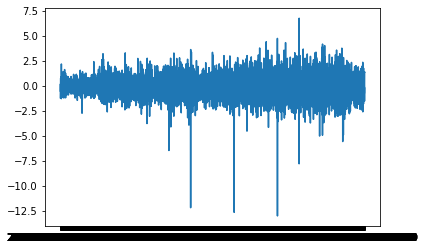

In [186]:
%%time
contract['fut_price_chg'] = contract['fut_price'] - contract['fut_price'].shift()
contract = contract[contract['fut_price_chg']!=0]
contract['opt_price_chg'] = contract['opt_price'] - contract['opt_price'].shift()
plt.plot(contract['ts'],contract['opt_price_chg'] - contract['delta']*contract['fut_price_chg'])

In [274]:
#train_set = pre_train_process(contract,0,1000,True)
train_set = pre_train_process_3(contract,0,500,True)
train_set

,y,x1,x2
1,0.474795,0.032826,0.018108
2,0.450109,0.032720,0.018022
3,0.448605,0.033019,0.018327
4,0.440088,0.032912,0.018214
5,0.451818,0.033093,0.018408
...,...,...,...
486,0.332177,0.040183,0.027186
487,0.313631,0.040344,0.027365
488,0.328205,0.039917,0.026843
489,0.329368,0.039803,0.026696


In [275]:
result = train_model(train_set)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     4315.
Date:                Tue, 25 Jan 2022   Prob (F-statistic):          1.54e-310
Time:                        17:39:26   Log-Likelihood:                 1699.1
No. Observations:                 490   AIC:                            -3392.
Df Residuals:                     487   BIC:                            -3380.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8414      0.123      6.855      0.000       0.600       1.083
x1            -8.4860      6.688     -1.269      0.205     -21.627       4.654
x2            -6.4392      5.404     -1.192      0.234     -17.057       4.178
==============================================================================
Omnibus:                      275.466   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7320.571
Skew:                           1.898   Prob(JB):                         0.00
Kurtosis:                      21.551   Cond. No.                     2.52e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [277]:
predict_set = predict_MV_delta(contract,500,100,result)
predict_set

,ts,delta,vega,days_to_expiry,fut_price,y_hat,MV_delta,test
30700,2022-01-03 11:20:00,0.679331,323.725948,24.173958,17567.80,-7.895049,0.209608,-0.469722
30759,2022-01-03 11:21:00,0.678480,323.628128,24.173264,17566.85,-7.880391,0.209739,-0.468741
30830,2022-01-03 11:22:00,0.675075,323.245835,24.172569,17563.00,-7.821821,0.210259,-0.464816
30869,2022-01-03 11:23:00,0.672469,322.946847,24.171875,17560.00,-7.777082,0.210653,-0.461815
30937,2022-01-03 11:24:00,0.674202,323.138443,24.171181,17562.00,-7.806822,0.210392,-0.463810
...,...,...,...,...,...,...,...,...
36642,2022-01-03 12:55:00,0.692886,322.805622,24.107986,17602.85,-8.129846,0.210871,-0.482015
36701,2022-01-03 12:56:00,0.693203,322.583146,24.107292,17605.85,-8.135370,0.211269,-0.481935
36812,2022-01-03 12:57:00,0.695624,322.713730,24.106597,17610.00,-8.177557,0.211101,-0.484523
36887,2022-01-03 12:58:00,0.694667,322.599821,24.105903,17608.95,-8.160883,0.211268,-0.483400
